# Explore the NOAA global temperature data set with pandas

Data from 
https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series

Every month:

Download csv file from https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/all/12/1850-2023/data.csv

One data point per year, average over 12 months, data from December:
Webpage: https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/12/12/1850-2023

CSV:
https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/12/12/1850-2023/data.csv


In [11]:
%config InlineBackend.figure_formats = ['svg']

In [12]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
!wget https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/12/12/1850-2023/data.csv


In [13]:
!head data.csv

Global Land and Ocean January - December Temperature Anomalies
Units: Degrees Celsius
Base Period: 1901-2000
Missing: -999
Year,Anomaly
1850,-0.17
1851,-0.09
1852,-0.10
1853,-0.12
1854,-0.11


In [14]:
df = pd.read_csv("data.csv", skiprows=4, index_col=0)

In [15]:
df

Anomaly
Year         
1850    -0.17
1851    -0.09
1852    -0.10
1853    -0.12
1854    -0.11
...       ...
2019     0.98
2020     1.01
2021     0.86
2022     0.91
2023     1.18

[174 rows x 1 columns]

In [16]:
ds = df['Anomaly']
ds

Year
1850   -0.17
1851   -0.09
1852   -0.10
1853   -0.12
1854   -0.11
        ... 
2019    0.98
2020    1.01
2021    0.86
2022    0.91
2023    1.18
Name: Anomaly, Length: 174, dtype: float64

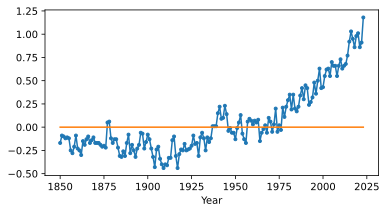

In [17]:
ax = ds.plot(style='.-', figsize=(6, 3))
ax.plot([ds.index.min(), ds.index.max()], [0, 0])

## Check the base line (1901 to 2000)

In [18]:
ds.loc[1901:2000].mean()

0.0005000000000000004

Odd, should be zero, shouldn't it?

## Which years were the hottest?

In [21]:
ds.sort_values(ascending=False)[0:15]

Year
2023    1.18
2016    1.03
2020    1.01
2019    0.98
2017    0.95
2015    0.92
2022    0.91
2018    0.86
2021    0.86
2014    0.77
2010    0.73
2005    0.70
2013    0.68
2006    0.66
2012    0.66
Name: Anomaly, dtype: float64

In [ ]:
ranking = ds.sort_values(ascending=False)
ranking.head()

<Axes: xlabel='Year'>

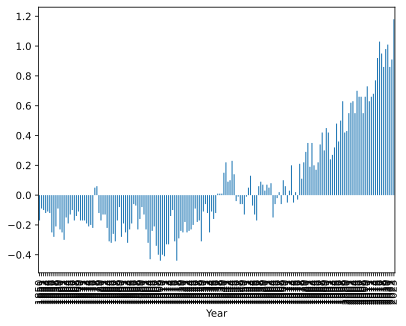

In [23]:
ds.plot(kind='bar')

<BarContainer object of 174 artists>

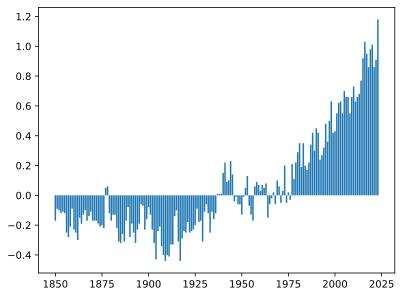

In [24]:
fig, ax = plt.subplots()
ax.bar(ds.index, ds.values)

## Short term extrapolation based on last 50 years?

In [25]:
def R2(a, b):
    """Given two data sets a and b as numpy arrays, return
    the sum of the squared pointwise differences. 
    could also call this the squared deviation."""
    return sum((a-b)**2)

def RMSD(a, b):
    """Given two data sets a and b as numpy arrays, return
    the root of the mean of the squared pointwise differences. 
    See https://en.wikipedia.org/wiki/Root-mean-square_deviation.
    """
    assert len(a) == len(b)
    return math.sqrt(R2(a, b) / len(a))

def compute_rmsd(model: callable, popt: np.ndarray , data: pd.Series):
    """
    Given the fitted `model`, the tuple of optimum parameters `popt`,
    and the original `data`, compute the average deviation of the fit 
    from the data points.
    The closer to zero this is, the better is the fit.
    """
    x = data.index
    y = data.values
    fit_y = model(data.index, *popt)
    rmsd = RMSD(y, fit_y)
    r2 = R2(y, fit_y)
    return rmsd

In [ ]:
max(ds.index)

In [26]:
l50 = ds.loc[1973:2023]
# l50 = dss.loc[max(ds.index)-50:max(ds.index)]

<Axes: xlabel='Year'>

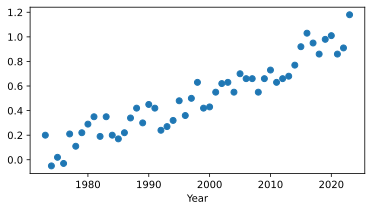

In [27]:
l50.plot(style='o', figsize=(6, 3))

In [28]:
import scipy.optimize

In [29]:
def deltaT(year, base, slope):
    """Given a year, return the linear approximation of temperature
    change for a given base and slope. The return value is
    `base + slope * year`.
    
    Slope is the temperature increase per year, i.e.
    dT/dyear."""
    return base + slope * year


In [30]:
popt, pcov = scipy.optimize.curve_fit(deltaT, l50.index, l50.values)
popt

array([-3.69936247e+01,  1.87683258e-02])

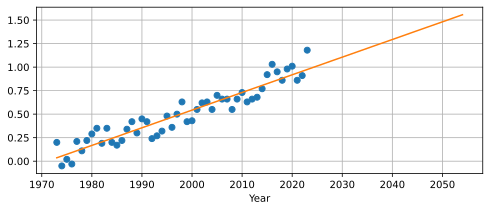

In [31]:
# plot fit with real data
fig, ax = plt.subplots(figsize=(8,3))
l50.plot(ax=ax, style='o')
years = np.arange(1973, 2055)
ax.grid('on')
ax.plot(years, deltaT(years, *popt))

In [32]:
def deltaT2(year, a, b, c):
    """Given a year, return the linear approximation of temperature
    change for a given base and slope. The return value is
    `a + b*year + c*year**2`
    """
    return a + b*year + c*year**2


In [48]:
popt2, pcov2 = scipy.optimize.curve_fit(deltaT2, l50.index, l50.values)
popt2

array([ 5.07515659e+02, -5.26315597e-01,  1.36407388e-04])

In [50]:
deltaT2(2000, popt2[0], popt2[1], popt2[2])

0.5140175432453589

In [51]:
deltaT2(2000, *popt2)

0.5140175432453589

In [ ]:
compute_rmsd(deltaT2, popt2, l50)

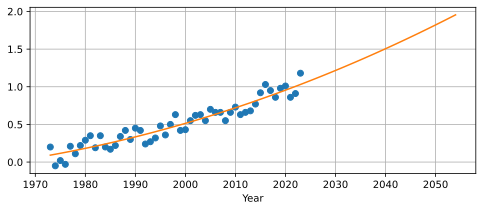

In [34]:
# plot fit with real data
fig, ax = plt.subplots(figsize=(8, 3))
l50.plot(ax=ax, style='o')
years = np.arange(1973, 2055)
ax.grid('on')
ax.plot(years, deltaT2(years, *popt2))

In [35]:
compute_rmsd(deltaT, popt, l50)

0.09551713316439608

In [36]:
compute_rmsd(deltaT2, popt2, l50)

0.09179014733061909

## When do we cross +1.5C?

In [37]:
from scipy.optimize import brentq

In [38]:
def helper(year):
    """helper function that returns zero, when deltaT(year) is 1.5."""
    return deltaT(year, *popt) - 1.5

In [39]:
def helper2(year):
    """helper function that returns zero, when deltaT(year) is 1.5."""
    return deltaT2(year, *popt2) - 1.5

In [40]:
brentq(helper, 2020, 2060)

2050.988733221252

In [41]:
brentq(helper2, 2020, 2060)

2039.8401711059507

## Or an exponential model?

In [42]:
def deltaT3(year, a, b, c):
    return a + b*np.exp((year-2000)/c)


In [43]:
popt3, pcov = scipy.optimize.curve_fit(deltaT3, l50.index, 
                                      l50.values, p0=(-1, 1, 1))
popt3

array([-0.70527814,  1.2167071 , 63.85784996])

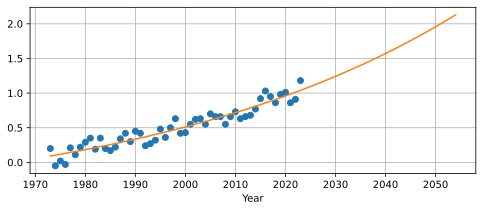

In [44]:
# plot fit with real data
fig, ax = plt.subplots(figsize=(8,3))
l50.plot(ax=ax, style='o')
years = np.arange(1973, 2055)
ax.grid('on')
ax.plot(years, deltaT3(years, *popt3))

In [45]:
compute_rmsd(deltaT3, popt3, l50)

0.09149428549800052

In [46]:
def helper3(year):
    """helper function that returns zero, when deltaT(year) is 1.5."""
    return deltaT3(year, *popt3) - 1.5

In [47]:
brentq(helper3, 2000, 2060)

2037.9766164407595

## Can we smooth the data?



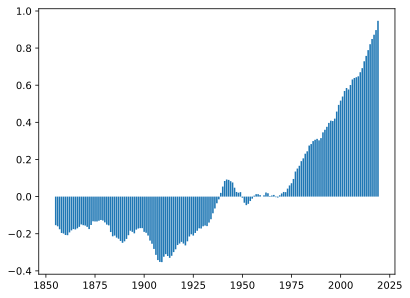

In [55]:
ds_smooth = ds.rolling(10, center=True).mean()
fig, ax = plt.subplots()
ax.bar(ds_smooth.index, ds_smooth.values)

dss = ds_smooth.dropna()